In [66]:
from __future__ import print_function
import numpy as np
import json
import glob 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
recipes = []
path = 'jsons/parsed*.json'   
files=glob.glob(path)   
for file in files: 
    with open(file) as f:
        for line in f:
            recipes.append(json.loads(line))

# Statistics

### Dataset Basic Information

In [47]:
print("There are {} recipes in this dataset".format(len(recipes)))

There are 4693 recipes in this dataset


In [48]:
print(type(recipes[0]))

<type 'dict'>


In [49]:
print(recipes[0].keys())

[u'rating', u'code', u'name', u'amounts', u'servings', u'calories', u'reviews', u'num_reviews', u'verbs', u'steps', u'time', u'tag', u'tips', u'ing', u'desc']


### Most Popular Ingredients

In [50]:
from collections import Counter

In [51]:
all_ings = [ing for ings in [recipe['ing'] for recipe in recipes] for ing in ings]
count = Counter(all_ings)
top_n =  count.most_common(10)

In [52]:
print ("The top 10 most commonly used ingredients are: \n\n{}".format
       ("\n".join(str(ing) for ing in top_n)))

The top 10 most commonly used ingredients are: 

(u'salt', 1728)
(u'butter', 1471)
(u'white sugar', 1327)
(u'all-purpose flour', 1212)
(u'egg', 1204)
(u'milk', 910)
(u'vanilla extract', 820)
(u'garlic', 807)
(u'olive oil', 596)
(u'vegetable oil', 556)


* Potential Challenge/To Do: Format ingredients to separate quantity/actual ingredient

### Rating Distribution

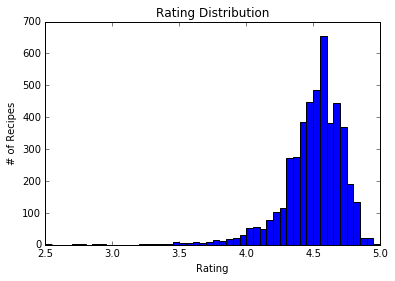

In [53]:
plt.hist([y['rating'] for y in recipes],bins= 50)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("# of Recipes")
plt.show()

* Potential Challenge/To Do: It seems as though our dataset only consists of recipes that already have high ratings. We need to expand our dataset in order to avoid selection bias.

### Cooking Time Distribution

In [54]:
import math

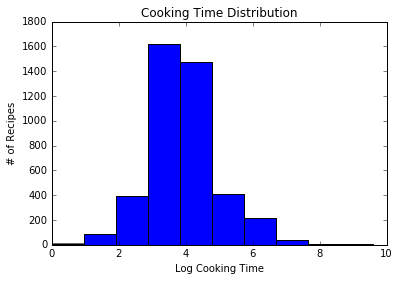

In [55]:
plt.hist([math.log(y['time']) for y in recipes if (y['time'] != -1)])
plt.title("Cooking Time Distribution")
plt.xlabel("Log Cooking Time")
plt.ylabel("# of Recipes")
plt.show()

* Probably a bug in the code thats encoding the times inconsistently. Discarded values over 1000 for now but still not making sense. Should take this plot out.

### Number of Reviews Distribution

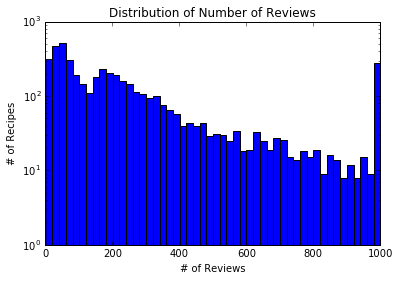

In [56]:
plt.hist([len(y['reviews']) for y in recipes], bins = 50, log = True)
plt.title("Distribution of Number of Reviews")
plt.xlabel("# of Reviews")
plt.ylabel("# of Recipes")
plt.show()

* The cutoff for maximum reviews seems to be 1000
* Why is the bin for 500 reviews empty...?
* Number of reviews seem pretty evenly distributed throughout the recipes. 

### Length of Recipe Distribution 

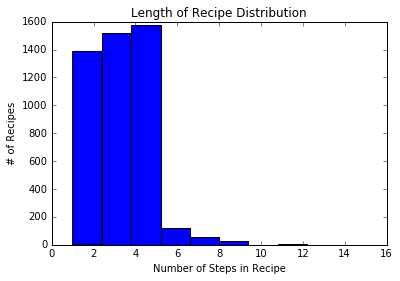

In [57]:
plt.hist([len(y['steps']) for y in recipes],bins= 10)
plt.title("Length of Recipe Distribution")
plt.xlabel("Number of Steps in Recipe")
plt.ylabel("# of Recipes")
plt.show()

## Building the Baseline Model

### Inverted Index

In [61]:
#dictionary of recipe name to recipe ingredients
recipe_ingredients = {}
for recipe in recipes:
    recipe_ingredients[recipe['name']] = recipe['ing']

id_to_name = {}


#inverted index of ingredient to doc IDs
inverted_index = {}
for i in range(len(recipes)):
    for ing in recipes[i]['ing']:
        if ing in inverted_index:
            recipe_indices = [x for x in inverted_index[ing]]
            if i in recipe_indices:
                continue
            else:
                inverted_index[ing].append(i)
        else:
            inverted_index[ing]=[i]
            
idf = {}
for ing in inverted_index.keys():
    num_docs = len(inverted_index[ing])
    idf[ing] = math.log(len(recipes)/float(1+num_docs),2)
    
norms = np.zeros(len(recipes))
for i in range(len(recipes)):
    norm = 0
    for ing in inverted_index.keys():
        for doc in inverted_index[ing]:
            if i == doc:
                norm = norm + (idf[ing])**2
    norms[i] = math.sqrt(norm)

In [90]:
#performs a search based on cosine similarity
def index_search(query, index, idf, norms, recipes):
    results = {}
    query_toks = query.split(",")
    norm_q = 0
    for ing in query_toks:      
        if ing not in index.keys():
            continue
        else:
            norm_q = norm_q + (idf[ing])**2
            for doc in index[ing]:              
                score = idf[ing] * idf[ing]
                if doc in results.keys():
                    results[doc] = results[doc] + score
                else:
                    results[doc] = score
    #normalizing
    for doc in results:
        results[doc] = results[doc]/(float(norms[doc])*(math.sqrt(norm_q)))
    #sorting
    results = sorted(results.items(), key=lambda x: x[1], reverse=True) 
    results = map (lambda t: (t[1], t[0]), results)
    new_results = []
    for (score, doc_id) in results:
        new_results.append(recipes[doc_id])
    
    return new_results[0:9]

index_search("eggs,flour,salt", inverted_index, idf, norms, recipes)

[{u'amounts': [u'1 cup butter, softened',
   u'1 2/3 cups white sugar',
   u'2 eggs',
   u'2 teaspoons vanilla extract',
   u'3 cups sifted cake flour',
   u'2 1/4 teaspoons baking powder',
   u'1/2 teaspoon salt',
   u'1 1/3 cups milk'],
  u'calories': 395,
  u'code': u'42148',
  u'desc': u'"Very simple, but delicious cake. Can be used with most any kind of frosting."',
  u'ing': [u'butter',
   u'white sugar',
   u'egg',
   u'vanilla extract',
   u'flour',
   u'powder',
   u'salt',
   u'milk'],
  u'name': u"Scottley's Basic Yellow Cake",
  u'num_reviews': 167,
  u'rating': 4.09,
  u'reviews': [{u'rating': 5,
    u'reviewer': u'1539479',
    u'text': u'I LOVE this recipe. I have used this recipe so much (sometimes modified with a bit more sugar) and it never fails me.  Its always moist and delicious.  It is hearty- definitely not like those "a...'},
   {u'rating': 5,
    u'reviewer': u'473745',
    u'text': u"Not to toot my own horn, but this recipe never lets me down.  To ensure prope